In [11]:
import csv
import os
import pandas as pd
import numpy as np
import copy
import time
import pickle

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB, CategoricalNB

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import normalize, LabelEncoder, MinMaxScaler

import sklearn.model_selection as model_selection
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, det_curve
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns


In [2]:
# usefull fucntions
def remove_nan_values(sample_array:np.array) -> np.array:
    for sample_index, i in enumerate(sample_array):
        for value_index, j in enumerate(i):
            if j==' ':
               sample_array[sample_index][value_index] = 0.0
            elif type(j) == str:
                sample_array[sample_index][value_index] = int(j)
            elif np.isnan(j):
               sample_array[sample_index][value_index] = 0.0
    return sample_array

def remove_1d_array_nan_values(sample_array: np.array, attack_categories: dict) -> np.array:
    for value_index, j in enumerate(sample_array):
        if j==' ':
           sample_array[value_index] = 0.0
        elif type(j) == str:
            try:
                sample_array[value_index] = int(j)
            except:
                sample_array[value_index] = attack_categories[j]
        elif np.isnan(j):
           sample_array[value_index] = 0.0
    return sample_array

def save_model(model, name, prefix) -> None:
    """Function responsible for saving trained model. It must be called
    after defining, training and predict.

    :param: None
    :return: None
    """

    filename = f"{name}_{prefix}.sav"
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filepath):
    """Function responsible for load model.

    :param: None
    :return: None
    """
    return pickle.load(open(filepath, 'rb'))


# def response_coding(xtrain, ytrain, feature):
#     dictionary = dict()
#     x = pd.DataFrame()
#     x = pd.DataFrame([feature, 'class 1', 'class 0'])

#     unique_cat_labels = xtrain[feature].unique()

#     for i in tqdm(range(len(unique_cat_labels))):
#         total_count = xtrain.loc[:,feature][(xtrain[feature] == unique_cat_labels[i])].count()
#         p_0 = xtrain.loc[:, feature][((xtrain[feature] == unique_cat_labels[i]) & (ytrain==0))].count()
#         p_1 = xtrain.loc[:, feature][((xtrain[feature] == unique_cat_labels[i]) & (ytrain==1))].count()

#         dictionary[unique_cat_labels[i]] = [p_1/total_count, p_0/total_count]

#         row = []
#         row.append(unique_cat_labels[i])
#         row.append(p_1/total_count)
#         row.append(p_0/total_count)
#         x.add_row(row)
#     return dictionary

In [3]:
dataset_testing_path = '/home/mkubita/Pulpit/Praca Magisterska/Zbiory danych/UNSW-NB15/UNSW-NB15 - CSV Files/Splitted_Dataset/UNSW_NB15_testing-set.csv'
dataset_traning_path = '/home/mkubita/Pulpit/Praca Magisterska/Zbiory danych/UNSW-NB15/UNSW-NB15 - CSV Files/Splitted_Dataset/UNSW_NB15_training-set.csv'


dataset_features_path = '/home/mkubita/Pulpit/Praca Magisterska/Zbiory danych/UNSW-NB15/UNSW-NB15 - CSV Files/NUSW-NB15_features.csv'

features_columns = pd.read_csv(dataset_features_path, sep=",", encoding='cp1252')
features_list = list(features_columns['Name'])

In [24]:
df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [29]:
# load multiple files
li = []
df = None
for csv_file in [dataset_testing_path, dataset_traning_path]:
    df = pd.read_csv(csv_file, index_col=None, header=0)
#     df.columns = features_list
    li.append(df)

frame = pd.concat(li, ignore_index=True)

In [4]:
# load data to pandas DataFrame
df_training = pd.read_csv(dataset_traning_path, index_col=None, header=0)
df_training = df_training.drop(df_training.columns[0], axis=1)

df_testing = pd.read_csv(dataset_testing_path, index_col=None, header=0)
df_testing = df_testing.drop(df_testing.columns[0], axis=1)

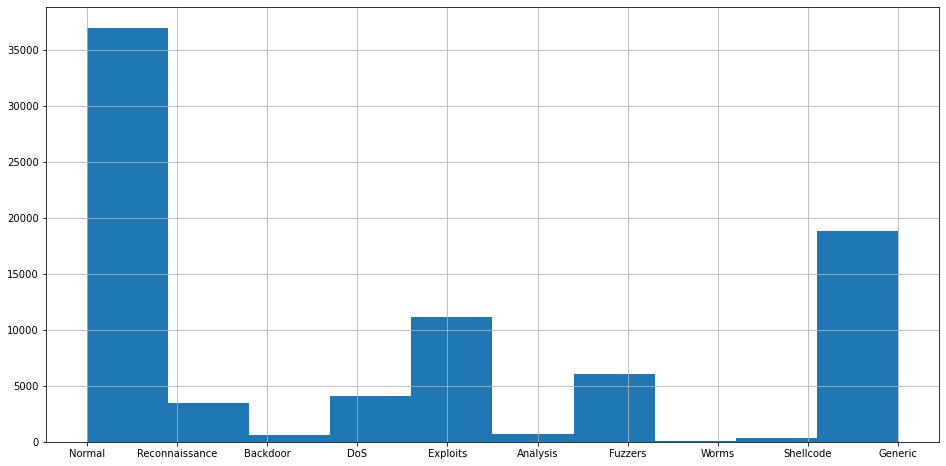

In [5]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.hist(df_testing['attack_cat'])
plt.show()

In [6]:
# features list
features_list = list(df_training.columns)
features_list.remove('attack_cat')
features_list.remove('label')

In [7]:
# categorical values
categorical_features = ['state', 'proto', 'service']

for categorical_feature in categorical_features:
    test_list = list(df_testing[features_list][categorical_feature].unique())

    label_encoding = {name: index for index, name in enumerate(list(df_training[features_list][categorical_feature].unique()))}
    for i in test_list:
        if i not in label_encoding.keys():
            label_encoding[i] = max(label_encoding.values()) + 1
    
    
    for name, value in label_encoding.items():
        df_training[features_list]= df_training[features_list].replace(name, value)
        df_testing[features_list]= df_testing[features_list].replace(name, value)


In [9]:
# prepare data for classification
x_train = df_training[features_list].to_numpy()
y_train = df_training['label'].to_numpy()

x_test = df_testing[features_list].to_numpy()
y_test = df_testing['label'].to_numpy()

# remove nan values
x_train = remove_nan_values(x_train)
x_test = remove_nan_values(x_test)


# normalization min max
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [10]:
x_train

array([[2.02463370e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.08317020e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.19672131e-02, 0.00000000e+00],
       [2.70521550e-02, 0.00000000e+00, 0.00000000e+00, ...,
        1.69491525e-02, 8.19672131e-02, 0.00000000e+00],
       ...,
       [1.50000028e-07, 7.57575758e-03, 5.00000000e-01, ...,
        3.38983051e-02, 1.80327869e-01, 0.00000000e+00],
       [1.50000028e-07, 7.57575758e-03, 5.00000000e-01, ...,
        4.91525424e-01, 4.75409836e-01, 0.00000000e+00],
       [1.50000028e-07, 7.57575758e-03, 5.00000000e-01, ...,
        4.91525424e-01, 4.75409836e-01, 0.00000000e+00]])

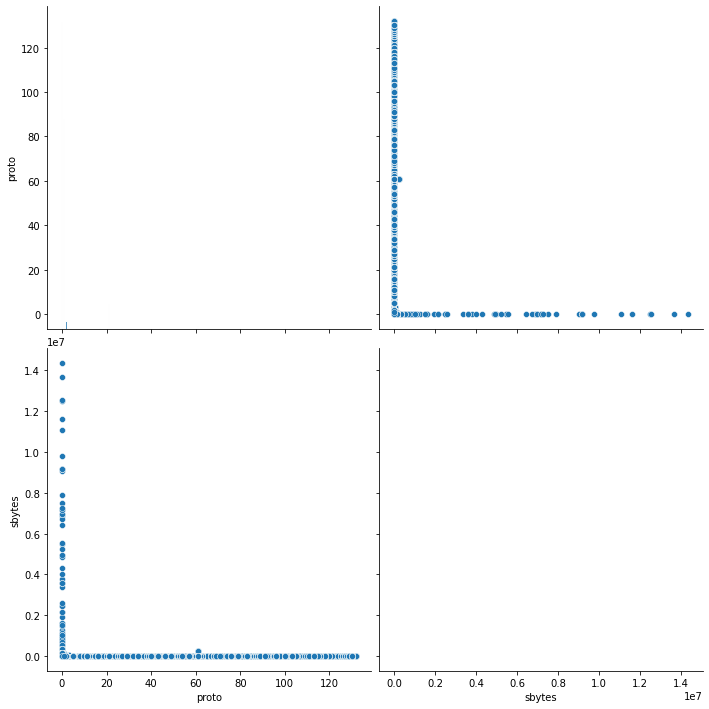

In [19]:
sns.pairplot(df_testing[['proto', 'sbytes']], height=5)
plt.show()

In [14]:
df_testing.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [ ]:
sns.pairplot(df_testing[['proto', 'sbytes']], height=5)
plt.show()

In [27]:
df_testing

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,1,0,1,2,0,496,0,90909.090200,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,1,0,1,2,0,1762,0,125000.000300,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,1,0,1,2,0,1068,0,200000.005100,254,...,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,1,0,1,2,0,900,0,166666.660800,254,...,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,1,0,1,2,0,2126,0,100000.002500,254,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,1,0,1,2,0,104,0,200000.005100,254,...,1,2,0,0,0,2,1,0,Normal,0
82328,1.106101,0,0,0,20,8,18062,354,24.410067,254,...,1,1,0,0,0,3,2,0,Normal,0
82329,0.000000,2,0,1,1,0,46,0,0.000000,0,...,1,1,0,0,0,1,1,1,Normal,0
82330,0.000000,2,0,1,1,0,46,0,0.000000,0,...,1,1,0,0,0,1,1,1,Normal,0


In [30]:
frame

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
257669,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
257670,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
257671,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [31]:
# categorical values
categorical_features = ['state', 'proto', 'service']

for categorical_feature in categorical_features:
    test_list = list(frame[features_list][categorical_feature].unique())

    label_encoding = {name: index for index, name in enumerate(list(frame[features_list][categorical_feature].unique()))}
    for i in test_list:
        if i not in label_encoding.keys():
            label_encoding[i] = max(label_encoding.values()) + 1
    
    
    for name, value in label_encoding.items():
        frame[features_list]= frame[features_list].replace(name, value)


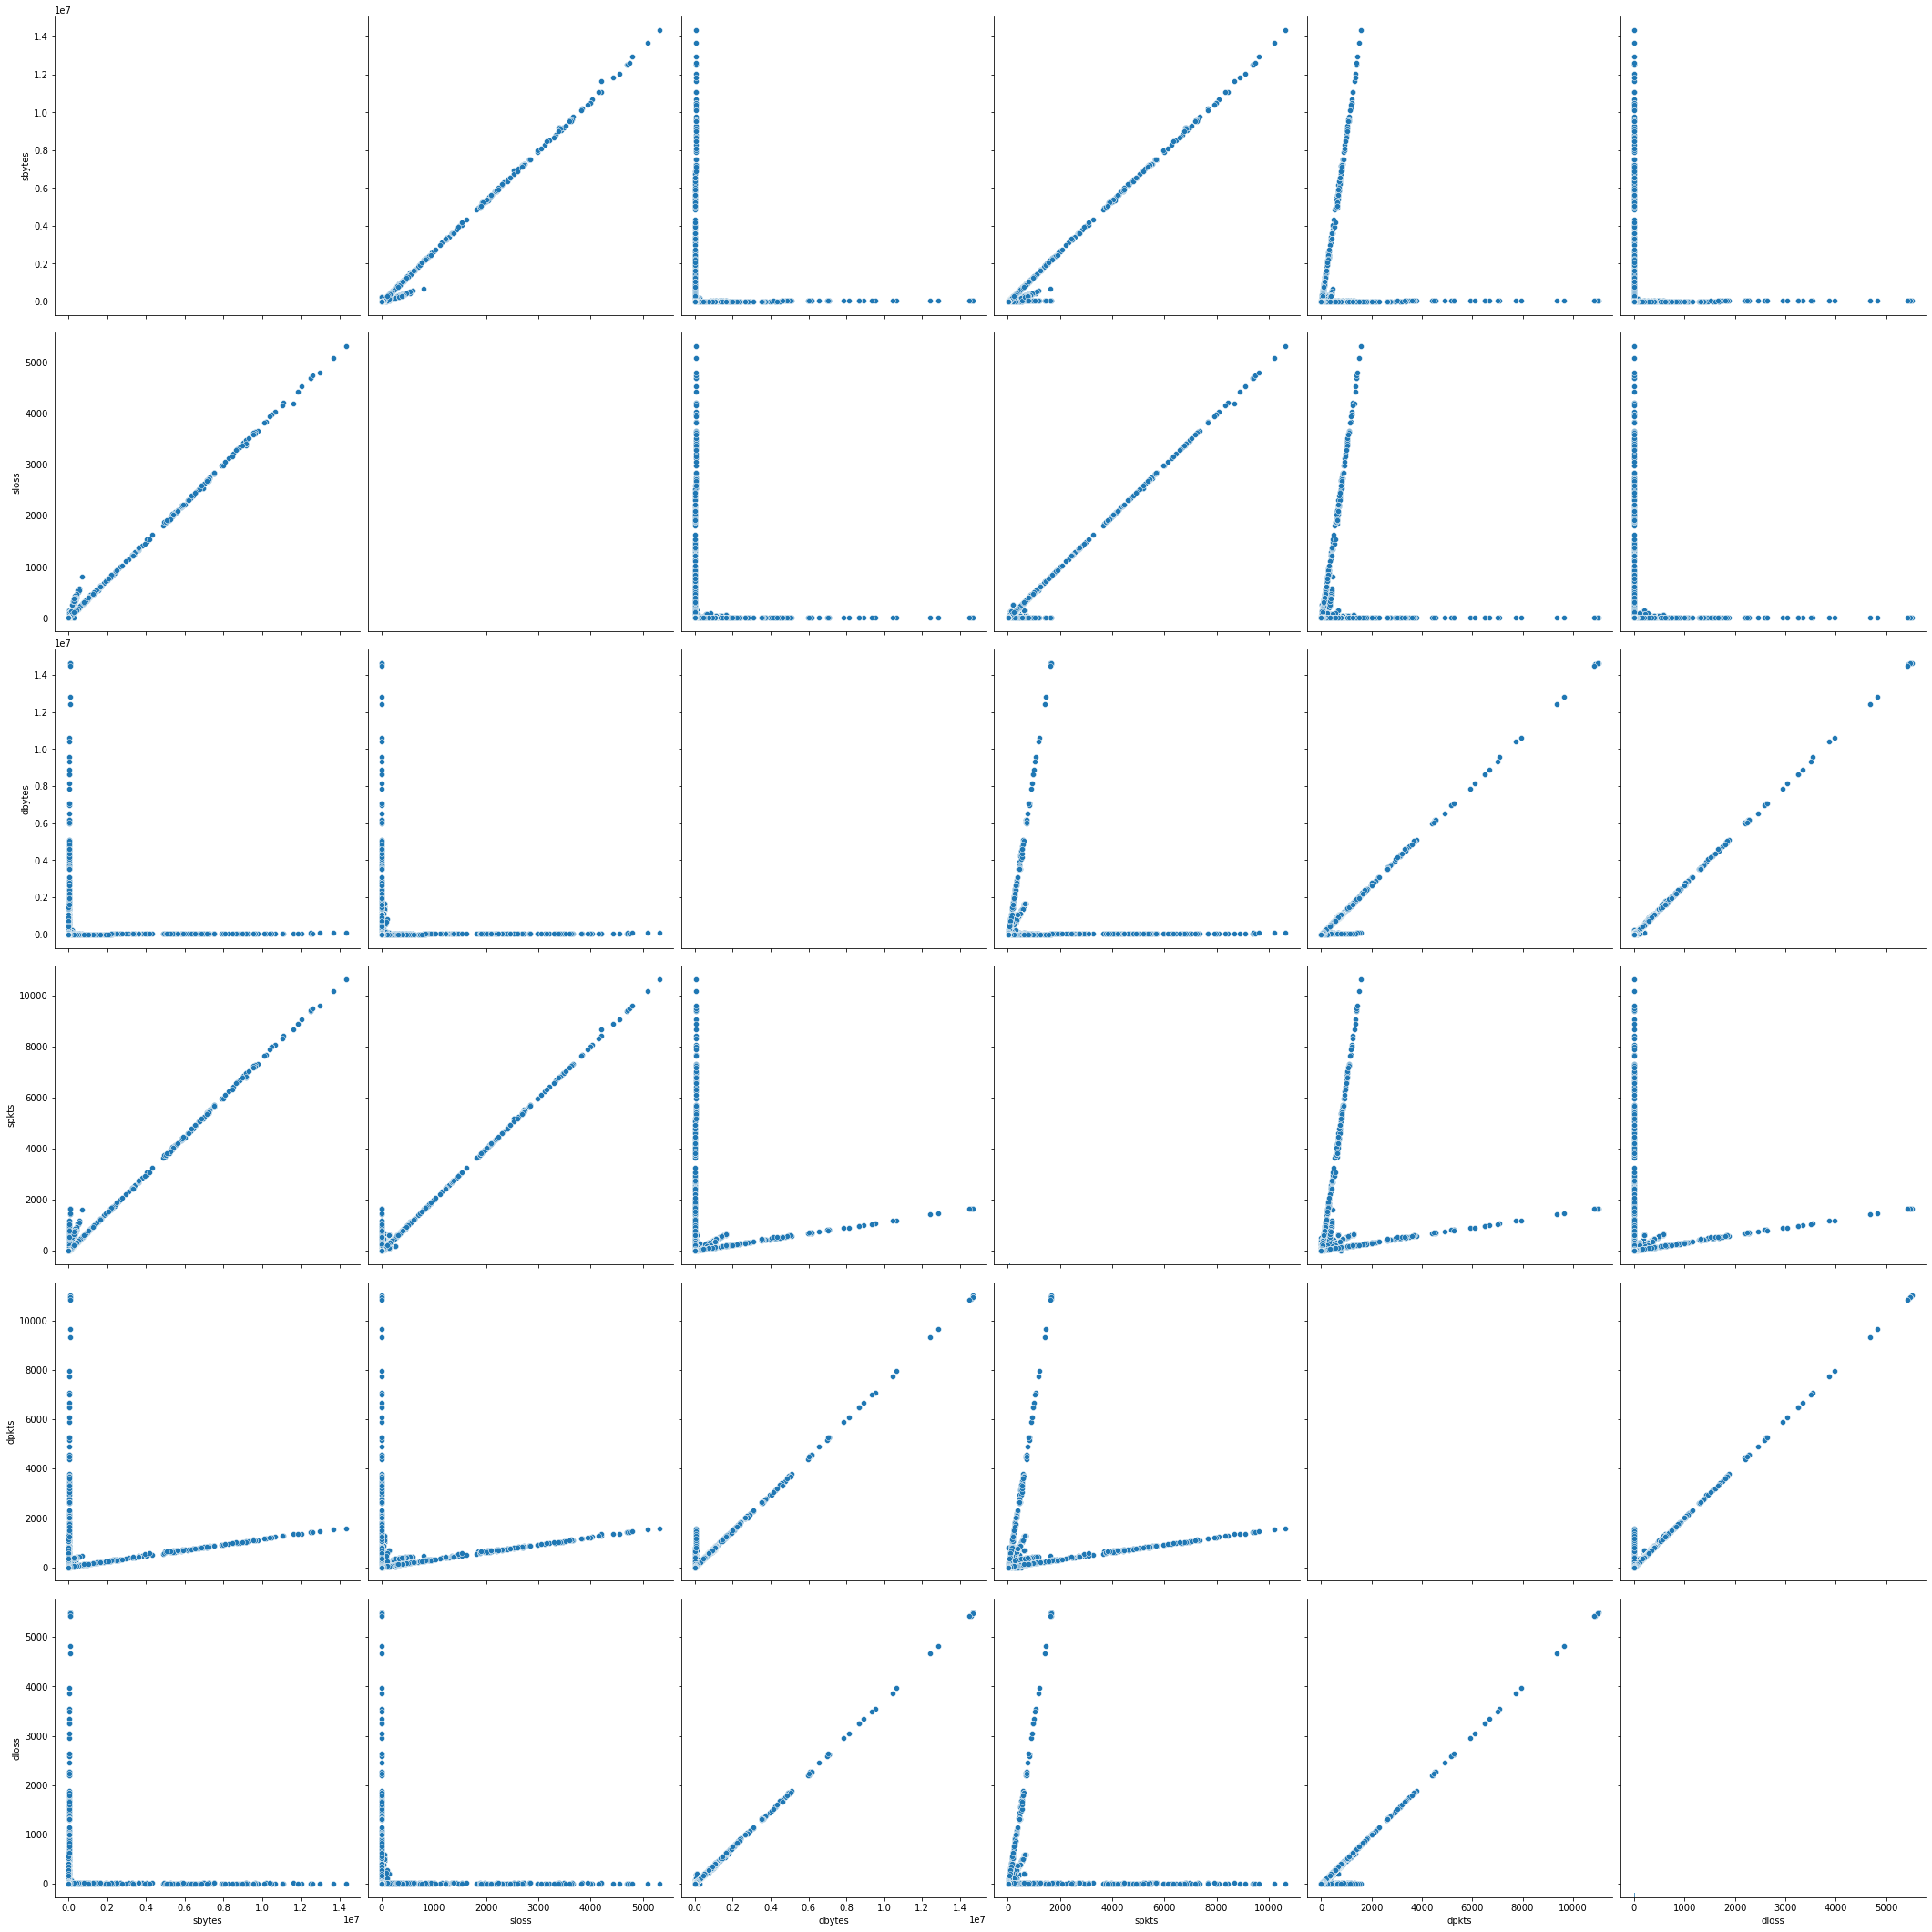

In [49]:
sns.pairplot(frame[['sbytes', 'sloss', 'dbytes', 'spkts', 'dpkts','dloss']], height=5)
plt.show()



In [47]:
frame[frame['label'] == 0].columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')